# Lecture Note on Gutzwiller approximation implementation

# <font color='red'> ROUTINE TO CREATE ENERGY LIST, $\epsilon_k$ </font>

In [11]:
import numpy as np

In [1]:
def get_1D_e_list(nmesh=500, t=0.5):
    """
    get 1D DOS energy list
    Input:
        nmesh: number of e points
        d: hlaf-bandwidth
    Output:
        e_list: list of e points
    """
    import numpy as np
    k_list = np.linspace(-np.pi,np.pi,nmesh)
    e_list = 2.*t*np.cos(k_list)
    return e_list

def get_semicircle_e_list(nmesh=500, d=1.0):
    """
    get semicircular DOS energy list
    Input:
        nmesh: number of e points
        d: hlaf-bandwidth
    Output:
        e_list: list of e points
    """
    import numpy as np
    dos = lambda e: 2./np.pi * np.sqrt(d-e**2)
    cdos = lambda e: ( e*np.sqrt(d-e**2) + np.arcsin(e) ) / np.pi + 0.5

    '''
    e_list = np.linspace(-1,1,100)
    plt.plot(e_list,dos(e_list))
    plt.plot(e_list,cdos(e_list))
    plt.plot(e_list,np.linspace(0,1,100))
    plt.show()
    quit()
    '''
 
    from scipy.optimize import bisect
    
    cdos_list = np.linspace(0,1,nmesh+1)
    e_list = [bisect(lambda x: cdos(x)-a, -1 ,1) for a in cdos_list]
    e_list = np.asarray(e_list)
    e_list = (e_list[1:] + e_list[0:-1])/2

    '''
    plt.plot(e_list,cdos(e_list),'o')
    plt.plot(e_list,cdos_list,'-')
    plt.show()
    quit()
    '''
    return e_list

# <font color='red'> EXACT DIAGONALIZATION ROUTINES </font>
Build the matrix representation of the fermion operators, $<n|c^\dagger_\alpha|m>$, in the basis of many-body Fock states $|n>$. The Fock states is stored in a string (config_b) representing the configuration of the state in a binary form, for example "010010"=18 represent the Fock states for which the orbital 2 and 5 are occupied. For all the fermion field, $c^\dagger_\alpha$, we loop through the Fock states (from 0 to $2^{no}$) to build the fermion matrices and store it into a list of sparse matrices.

In [2]:
def build_fermion_op(no):
    '''
    Build fermionic operators for each spin+orbitals, alpha, with size 
    of Hilberspace, A and B.
    Input:
        no: number of orbital
    Output:
        FH_list: a list of fermionic operator <A|[f^dagger_alpha]|B>
    '''
    import numpy as np
    from scipy.sparse import csr_matrix
    
    hsize = 2**no # size of Hilbert space
    strb = '{0:0'+str(no)+'b}' # string to save binary configuration
    FH_list = []
    #print 'Hibert space size:', hsize
    for o in range(no): #calculate FH for each orbital
        #print 'building FH for orbital:', o
        row = [] #storing row index for 
        col = [] #storing col index for
        data = [] #storing data for (row, col)
        for b in range(hsize): # col |B>
            config_b = strb.format(b) # cofiguration correspond to B
            #print config_b #print binary configuration
            #print config_b[5]
            if config_b[o] == '0':
                col.append(b)
                config_a = ''
                #calculate the corresponding <A|
                for i in range(no):
                    if i == o:
                        config_a += '1'
                    else:
                        config_a += config_b[i]
                a = int(config_a,2)
                row.append(a)
                #calculate the exponent for minus sign
                expo = 0
                for i in range(o):
                    expo += int(config_b[i])
                data.append((-1.)**(expo))
                #print config_a
                #print config_b
                #print (-1.)**(expo), expo
        #print '<|=',row
        #print '|>=',col
        #print 'data=',data
        #assign values into sparse matrix
        FH = csr_matrix((data, (row, col)), shape=(hsize, hsize), dtype=float)
        #print FH.toarray()
        FH_list.append(FH)
    return FH_list

Build the embedding Hamiltonian matrix with the above fermion matrix.

In [3]:
def build_Hemb_matrix(D, H1E, LAMBDA, V2E, FH_list):
    '''
    Build Hemb matrix.
    Input:
        D: hybridization matrix
        H1E: local one-body
        LAMBDA: bath one-body
        V2E: local two-body interaction
        FH_list: fermion operator list
    Return:
        Hemb: embedding Hamiltonian
    '''
    import numpy as np
    from scipy.sparse import csr_matrix
    
    no = 2*D.shape[0]
    hsize = 2**no
    Hemb = csr_matrix((hsize,hsize), dtype=complex)
    #build local one-body part
    for i in range(no//2):
        for j in range(no//2):
            #print i, j
            Hemb += H1E[i,j]*FH_list[i].dot( FH_list[j].getH() )
    #build hybridization part
    for i in range(no//2):
        for j in range(no//2):
            Hemb += D[i,j]*FH_list[j].dot( FH_list[i+no//2].getH() )
            Hemb += D[i,j].conj()*FH_list[i+no//2].dot( FH_list[j].getH() )
    #build bath part
    for i in range(no//2):
        for j in range(no//2):
            Hemb += LAMBDA[i,j]*FH_list[j+no//2].getH().dot( FH_list[i+no//2] )
    #build local two-body part
    for i in range(no//2):
        for j in range(no//2):
            for k in range(no//2):
                for l in range(no//2):
                    #print i,j,k,l
                    Hemb += 0.5*V2E[i,j,k,l]*FH_list[i].dot( FH_list[k].dot( FH_list[l].getH().dot(FH_list[j].getH() ) ) )

    return Hemb

Diagonalize the above embedding Hamiltonian matrix plus a penalty on $S^2$ to obtain the ground state energy and eigenvector for which $<S^2>=0$.

In [4]:
def solve_Hemb(D, H1E, LAMBDA, V2E, FH_list, idx, spin_pen, verbose=0):
    '''
    solve embeding Hamiltonian.
    Input:
        D: hybridization matrix
        H1E: local one-body
        LAMBDA: bath one-body
        V2E: local two-body interaction
        FH_list: fermion operator list
        idx: index for the orbital (also idx+1) where the double occupancy is calculated.
        spin_pen: prefactor for the S^2 penalty term.
    Return:
        density matrix
        double occupancy
    '''
    import numpy as np
    from scipy.sparse import csr_matrix
    from scipy.sparse.linalg import eigsh
    import primme
    
    no = 2*D.shape[0]
    hsize = 2**no
    #print '# of orbitals=',no

    Hemb = build_Hemb_matrix(D, H1E, LAMBDA, V2E, FH_list)

    #build spin operators:
    #build total spin operators S+
    Sp = csr_matrix((hsize,hsize), dtype=complex)
    for i in range(no//2):
        Sp += FH_list[2*i].dot(FH_list[2*i+1].getH())
        #f.write('    +1.0*OppC{}*OppA{}\n'.format(2*_i, 2*_i+1))
    #build total spin operators S-
    Sm = csr_matrix((hsize,hsize), dtype=complex)
    for i in range(no//2):
        Sm += FH_list[2*i+1].dot(FH_list[2*i].getH())
        #f.write('    +1.0*OppC{}*OppA{}\n'.format(2*_i+1, 2*_i))
    Sz = csr_matrix((hsize,hsize), dtype=complex)
    for i in range(no//2):
        Sz += ( 0.5*FH_list[2*i].dot(FH_list[2*i].getH()) - 0.5*FH_list[2*i+1].dot(FH_list[2*i+1].getH()) )
        #f.write('    +0.5*OppC{}*OppA{}-0.5*OppC{}*OppA{}\n'.format(2*_i, 2*_i, 2*_i+1, 2*_i+1))
    #build S^2 operator
    S2 = Sm.dot(Sp)+Sz.dot(Sz)+Sz

    #add spin penalty:
    Hemb += spin_pen*S2

    num_eig = 2 # print number of eigenvalues
    # using scipy.eigsh
    #vals, vecs = eigsh(Hemb, k=num_eig, which='SA')
    # using primme.eigsh
    vals, vecs = primme.eigsh(Hemb, num_eig, tol=1e-12, which='SA')
    if verbose ==1:
        print( 'eigenvalues=',vals )
    f = open('EMBED_ENE_S2.dat','w')
    print( '# Energy        S^2', file=f)
    for i in range(num_eig):
        print( vals[i], vecs[:,i].conj().T.dot( S2.dot( vecs[:,i] ) ), file=f)
    f.close()

    dm = calc_density_matrix(FH_list,vecs[:,0])
    #print 'density matrix='
    #print dm
   
    return dm, calc_double_occ(idx,FH_list,vecs[:,0]), vecs[:,0]

Calculate the double occupancy for orbital idx using the solved eigenvector.

In [5]:
def calc_double_occ(idx,FH_list,vec):
    '''
    calculate double occupancy at orbital idx.
    Input:
        idx: index for the orbital (also idx+1) where the double occupancy is calculated.
        FH_list: fermion operator list.
        vec: ground state eigenvector.
    Return:
        double occupancy
    '''
    import numpy as np
    from scipy.sparse import csr_matrix

    return vec.conj().T.dot( FH_list[idx].dot( FH_list[idx].getH().dot( 
             FH_list[idx+1].dot( FH_list[idx+1].getH().dot( vec ) ) ) ) )

Calculate the density matrix $\rho_{\alpha,\beta}=<c^{\dagger}_\alpha c_\beta>$ using the solved eigenvector.

In [6]:
def calc_density_matrix(FH_list,vec):
    '''
    calculate density matrix.
    Input:
        FH_list: fermion operator list
        vec: ground state eigenvector
    Return:
        dm: density matrix
    '''
    import numpy as np
    from scipy.sparse import csr_matrix
    
    no = len(FH_list)
    dm = np.zeros((no,no),dtype=complex)
    for i in range(no):
        for j in range(no):
            dm[i,j] = vec.conj().T.dot( FH_list[i].dot( FH_list[j].getH().dot( vec ) ) )
    return dm

# <font color='red'> CONVENIENCE ROUTINES: GENERIC </font>

<font color='green'> FUNCTION OF A MATRIX </font>

The function below computes any function $f$ of a generic Hermitian Matrix $H$:
$$f(H):=U f(E) U^\dagger\,,$$
where $U^\dagger H U = E$ is diagonal and $U$ is unitary.

In [7]:
def funcMat(H, function, beta=False, pr=False):
    import numpy as np
    from scipy.linalg import eigh
    N = H.shape[0]
    #print np.max(H.conj().T-H)
    assert(H.shape[0] == H.shape[1])
    assert(np.allclose(H.conj().T,H))#,rtol=1e-05, atol=1e-05))

    #
    eigenvalues,U = eigh(H)
    Udagger = U.conj().T
    if pr:
        print( eigenvalues )
    #
    if beta == False:
        functioneigenvalues = function(eigenvalues)
    else:
        functioneigenvalues = function(eigenvalues,beta)
    
    if pr:
        print( functioneigenvalues )
    functionE = np.zeros(U.shape,dtype=complex)
    functionE[np.arange(N), np.arange(N)] = functioneigenvalues
    functionH =  np.dot(np.dot(U,functionE),Udagger)
    #print functionE
    #
    return functionH


<font color='green'> MANIPULATION OF LISTS OF HERMITIAN MATRICES </font>

Construct a basis of $N\times N$ Hermitian matrices $\big\{h_{s}\,|\,s\in\{1,...,N^2\}\big\}$, orthonormal with respect to the standard inner product:
$ \text{Tr}\big[h^{\dagger}_{s}h_{s'}\big]= \delta_{ss'}$, and the corresponding list of transposed matrices $\big\{^{t}h_{s}\,|\,s\in\{1,...,N^2\}\big\}$.

In [8]:
def Hermitian_list(N):
    H_list=[]
    tH_list=[]
    #
    Z=np.zeros((N,N),dtype=complex)
    for i in range(N):
        H=Z*1.0
        H[i,i]=1.0
        H_list.append(H*1.0)
        tH_list.append(H*1.0)
    #
    for i in range(N):
        for j in range(i+1,N):
            H=Z*1.0
            H[i,j]=1.0
            H[j,i]=1.0
            H_list.append(H/np.sqrt(2.0))
            tH_list.append(H/np.sqrt(2.0))
            H=Z*1.0
            H[i,j]=1.0j
            H[j,i]=-1.0j
            H_list.append(H/np.sqrt(2.0))
            tH_list.append(np.transpose(H)/np.sqrt(2.0))
    #
    assert(len(H_list)==N**2)
    return H_list, tH_list

In [13]:
Hermitian_list(3)

([array([[1.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j]]),
  array([[0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 1.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j]]),
  array([[0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 1.+0.j]]),
  array([[0.        +0.j, 0.70710678+0.j, 0.        +0.j],
         [0.70710678+0.j, 0.        +0.j, 0.        +0.j],
         [0.        +0.j, 0.        +0.j, 0.        +0.j]]),
  array([[ 0.+0.j        ,  0.+0.70710678j,  0.+0.j        ],
         [-0.-0.70710678j,  0.+0.j        ,  0.+0.j        ],
         [ 0.+0.j        ,  0.+0.j        ,  0.+0.j        ]]),
  array([[0.        +0.j, 0.        +0.j, 0.70710678+0.j],
         [0.        +0.j, 0.        +0.j, 0.        +0.j],
         [0.70710678+0.j, 0.        +0.j, 0.        +0.j]]),
  array([[ 0.+0.j        ,  0.+0.j        ,  0.+0.70710678j],
         [ 0.+0.j        ,  0.+0.j        ,  0.+0.j        ],
         

Given an $N^2$-dimensional array of real coefficients $x$ and list of matrices $\big\{h_{s}\,|\,s\in\{1,...,N^2\}\big\}$, construct linear combination:  $H = \sum_s x_s h_s$ (which is a generic $N\times N$ Hermitian matrix).

In [9]:
def realHcombination(x,H_list):
    M=len(x)
    N=H_list[0].shape[0]
    assert(H_list[0].shape[0]==H_list[0].shape[1])
    assert(len(x)==len(H_list))
    #
    H=np.zeros((N,N))
    for i in range(M):
        H = H + x[i] * H_list[i]
    #
    return H

Given a generic Hermitian $N\times N$ matrix $H$ extract the $N^2$-dimensional array of coefficients $x$
such that $H = \sum_s x_s h_s$, where $\big\{h_{s}\,|\,s\in\{1,...,N^2\}\big\}$ is an ordered list of Hermitian matrices constructed consistently with the convention utilized above in this code.

In [10]:
def inverse_realHcombination(H,H_list):
    N=H_list[0].shape[0]
    H_list,tH_list=Hermitian_list(N)
    M=len(H_list)
    assert(H.shape[0]==H.shape[1])
    assert(M==N**2)
    #
    x_list=[]
    for i in range(M):
        x_list.append(np.trace(np.dot(H_list[i],H)))
    x=np.array(x_list)
    #
    return x


Given a $2N^2$-dimensional array of real coefficients $v=(x,y)$ --- whose first $N$ components form a real array $x$ and the remaining components form a real array $y$, --- and list of matrices $\big\{h_{s}\,|\,s\in\{1,...,N^2\}\big\}$, construct the linear combination:  $M = \sum_{s=1}^{N^2} (x_s + i y_s)\, h_s$ (which is a generic complex $N\times N$ matrix).

In [11]:
def complexHcombination(v,H_list):
    twiceM=len(v)
    M=twiceM//2
    N=H_list[0].shape[0]
    assert(twiceM % 2 == 0) # Checking that dimension of v is even
    assert(H_list[0].shape[0]==H_list[0].shape[1])
    assert(len(v)==2*len(H_list))
    #
    x=v[0:M]
    y=v[M:twiceM]
    H=np.zeros((N,N))
    for i in range(M):
        H = H + x[i] * H_list[i]
    for i in range(M):
        H = H + 1j*y[i] * H_list[i]
    #
    return H

Given a generic complex $N\times N$ matrix $H$ extract the $2N^2$-dimensional real array of coefficients $v=(x,y)$ --- whose first $N$ components form a real array $x$ and the remaining components form a real array $y$ ---
such that $H = \sum_{s=1}^{N^2} (x_s + i y_s)\, h_s$, where $\big\{h_{s}\,|\,s\in\{1,...,N^2\}\big\}$ is an ordered list of Hermitian matrices constructed consistently with the convention utilized above in this code.

In [12]:
def inverse_complexHcombination(H,H_list):
    N=H_list[0].shape[0]
    H_list,tH_list=Hermitian_list(N)
    M=len(H_list)
    assert(H.shape[0]==H.shape[1])
    assert(M==N**2)
    #
    xr_list=[]
    xi_list=[]
    for i in range(M):
        xr_list.append( np.real( np.trace(np.dot(H_list[i],H) ) ) )
        xi_list.append( np.imag( np.trace(np.dot(H_list[i],H) ) ) )
    xr=np.array(xr_list)
    xi=np.array(xi_list)
    #
    return np.hstack((xr,xi))


<font color='green'> LOEWNER MATRIX DERIVATIVE </font>

Calculate the derivative of a generic function $f$ of an Hermitian matrix
$$
D := \lim_{t\rightarrow 0} \frac{f(A + t H) - f(A)}{t}
$$
utilizing the Loewner Theorem (which is valid even if $A$ and $H$ do not commute).

In [13]:
def dF(A, H, function, d_function):
    from scipy.misc import derivative
    from numpy.linalg import eigh
    evals, evecs = eigh(A)
    Hbar = np.dot(np.conj(evecs).T, np.dot( H, evecs) ) # transform H to A's basis
    #create Loewner matrix in A's basis
    loewm = np.zeros(evecs.shape,dtype=complex)
    for i in range(loewm.shape[0]):
        for j in range(loewm.shape[1]):
            if i==j:
                loewm[i,i] = d_function(evals[i]) # derivative(function, evals[i], dx=1e-12)
            if i!=j:
                if evals[i] != evals[j]:
                    loewm[i,j]= ( function(evals[i]) - function(evals[j]) )/(evals[i]-evals[j])
                else:
                    loewm[i,j] = d_function(evals[i]) # derivative(function, evals[i], dx=1e-12)

    # Perform the Schur product in A's basis then transform back to original basis.
    deriv = np.dot(evecs, np.dot( loewm*Hbar, np.conj(evecs).T ) )
    return deriv

Calculate matrix of fermion function

In [14]:
def calc_C(H,beta):
    from numpy.linalg import eigh
    N = H.shape[0]
    assert(H.shape[0] == H.shape[1])
    #
    #print "H in calc_C"
    #print H
    C = funcMat(H, calc_Fermi0, beta)
    #
    return C

Functions that are used in the GA calculations

In [15]:
def denR(x):
    return (x*((1.0+0.j)-x))**(-0.5)

def denRm1(x):
    return (x*((1.0+0.j)-x))**(0.5)

def ddenRm1(x):
    return ((0.5-x)/(x*((1.0+0.j)-x))**0.5)

def calc_Fermi0(x,beta):
    """
    calculate the fermi function for a vector x. Sometimes smearing the fermi function can 
    lead to better convergence (but also lead to ficticious result if beta is too small).
    """
    f=[]
    for xx in x:
    #    if abs(xx)<1.e-12:
    #        f.append(0.5)
    #    elif xx< -1.e-12:
    #        f.append(1)
    #    elif xx> 1.e-12: 
    #        f.append(0)
    #
        f.append(1./(1+np.exp(beta*xx)))
    return np.array(f)

# <font color='red'> ROUTINES FOR CALCULATING GA EQUATIONS (CAN ALSO BE USED IN TIME DEPENDENT CASE) </font>


Given $R$ and $\lambda$, calculate density matrices at each k points, $\rho_{k}^{ab}$.

In [16]:
def calc_rhok(R, Lambda, ek_list, beta):
    import numpy as np
    return list(map(lambda x: calc_C( np.dot(R, np.dot(x, R.conj().T ) ) + Lambda, beta).T, ek_list))

Given $\rho_{k}^{ab}$, compute the $\tilde{\nu}\times\tilde{\nu}$ density matrix $\Delta_p=\frac{1}{\mathcal{N}}\sum_{k} \rho_{k}^{ab}$

In [17]:
def calc_Delta_p(rhok_list):
    return sum(rhok_list)/len(rhok_list)

Given $\rho_{k}^{ab}$ and $\Delta_p,\mathcal{R}$, calculate $\mathcal{D}$ from the equation below:
$$
\sum_c \mathcal{D}_{c\alpha}
\left[\Delta_p\left(1-\Delta_p\right)\right]^{\frac{1}{2}}_{ac}=
\frac{1}{\mathcal{N}}
\sum_k\sum_b \big[
\epsilon_k\mathcal{R}^\dagger\big]_{\alpha b}\,
\rho_{k}^{ab}\,,
$$
where $\epsilon_k$ is the dispersion corresponding to the non-local component of the Hamiltonian
generating the time evolution.

Note that $\mathcal{D}$ is non-zero only within the rectangular $\tilde{\nu}\times\nu$ block corresponding to the first $\nu$ columns.

In [18]:
def calc_D(R, Lambda, Delta_p, ek_list, rhok_list):
    import numpy as np
    Left=map(lambda x: np.dot( np.dot(ek_list[x], R.conj().T ), rhok_list[x].T ), range(len(rhok_list)))
    Left=sum(Left)/float(len(rhok_list))
    #print "Left="
    #print Left[::2,::2]
    Right=funcMat(Delta_p, denR)
    #print "Right="
    #print Right[::2,::2]
    #print ""
    #print np.dot(Right,np.transpose(Left))
    return np.dot(Right,np.transpose(Left))

Given $\Delta,\mathcal{R},\mathcal{D}$ computed above, calculate the real array $l^c$, with components $\big\{l^c_{s}\,|\,s\in\{1,...,\tilde{\nu}^2\}\big\}$, utilizing the following equation:

$$\left[\sum_{cb\alpha}\frac{\partial}{\partial d_{s}}\left[\Delta\left(1-\Delta\right)\right]^{\frac{1}{2}}_{cb} \,\mathcal{D}_{b\alpha}\mathcal{R}_{c\alpha}+\text{c.c.}\right]
+l^c_{s}+l_{s}=0\,,$$
where $d_s$ are the components of $\Delta$ computed in the step (1) above, and 
$$
\frac{\partial}{\partial d_{s}}\left[\Delta\left(1-\Delta\right)\right]^{\frac{1}{2}} :=
\lim_{d_{s}\rightarrow 0}
\frac{\left[(\Delta+d_{s}\,^{t}h_{s})\left(1-(\Delta+d_{s}\,^{t}h_{s})\right)\right]^{\frac{1}{2}}-\left[\Delta\left(1-\Delta\right)\right]^{\frac{1}{2}}}{d_{s}}\,,
$$
which can be computed utilizing the Loewner Theorem, as implemented in the convenience routine above.

From the array $l^c$, compute the corresponding matrix:

$$
\lambda^c(t_n) = \sum_{s=1}^{\tilde{\nu}^2} l_{s}^c \,h_{s}\,,
$$
where $\big\{h_{s}\,|\,s\in\{1,...,\tilde{\nu}^2\}\big\}$ is the ordered orthonormal basis of Hermitian matrices generated by the convenience routines above. 

In [19]:
#def calc_Lambda_c(R, Lambda, Delta_p, D, H_list, tH_list):
#    import numpy as np
#    l=inverse_realHcombination(Lambda,H_list)
#    lc=np.copy(l)*0.0
#    MM=np.dot(D,np.transpose(R))
#    for k in range(no*no):
#        AA=Delta_p
#        HH=tH_list[k]
#        derivative=dF(AA,HH, denRm1, ddenRm1)
#        tt=np.trace(np.dot(MM,derivative))
#        lc[k]=-l[k]-(tt+np.conjugate(tt))
#    # Equation 3 (l_c)
#    Lambda_c=realHcombination(lc,H_list)
#    return Lambda_c

def calc_Lambda_c(R, Lambda, Delta_p, D, H_list):
    """ Compute Lambda_c matrix
    """         
    no = Lambda.shape[0]
    l=inverse_realHcombination(Lambda,H_list)
    lc=np.copy(l)*0.0
    MM=np.dot(D,np.transpose(R))
    for k in range(len(H_list)):
        AA=Delta_p  
        HH=H_list[k].T
        derivative=dF(AA,HH, denRm1, ddenRm1)
        tt=np.trace(np.dot(MM,derivative))
        lc[k]=-l[k]-(tt+np.conjugate(tt)).real
    Lambda_c=realHcombination(lc,H_list)
    return Lambda_c 
                    
def calc_Lambda(R, Lambda_c, Delta_p, D, H_list):
    """ Compute Lambda_c matrix
    """     
    no = Lambda_c.shape[0]
    lc=inverse_realHcombination(Lambda_c,H_list)
    l=np.copy(lc)*0.0
    MM=np.dot(D,np.transpose(R))
    for k in range(len(H_list)):
        AA=Delta_p
        HH=H_list[k].T
        derivative=dF(AA,HH, denRm1, ddenRm1)
        tt=np.trace(np.dot(MM,derivative))
        l[k]=-lc[k]-(tt+np.conjugate(tt)).real
    Lambda=realHcombination(l,H_list)
    return Lambda


Given $R$, $\Lambda_c$, $D$, local one-body term $E$, two-body term $U_{i,j,k,l}$, Fock representation of fermion operators $F^{\dagger}_{i,j}$, the index for which the double occupancy is calculated, and the spin penalty, solve the density matrix and double occupancy corresponding to the ground state of $H_{emb}|\Phi\rangle=E|\Phi\rangle$.

In [20]:
def solve_embedding_problem(D, Lambda_c, ed_list, U_list, no, verbose):
    #create local one-body and two-body interaction
    E = np.zeros((no,no),dtype=complex)
    for l in ed_list:
        E[l[0],l[1]]=l[2]
    Umatrix=np.zeros((no,no,no,no),dtype=complex)
    for l in U_list:
        Umatrix[l[0],l[2],l[1],l[3]]=l[4]

    denMat, docc, Phi = solve_Hemb(D, E, Lambda_c, Umatrix, FH_list, i_docc, 0.05, verbose)
    return denMat, docc, Phi

# <font color='red'> GA GROUND STATE CALCULATION (WITHOUT DISENTANGLE TRICK)</font>

## The root problem that has to be solved in GA

In [22]:
def iterative_GA(R, Lambda, no, ek_list, ed_list, U_list, i_docc, FH_list, beta, verbose):
    """
    Iterative GA root solver
    """
    import numpy as np
    
    tol = 1e-5
    max_iter = 100
    mix = 0.4

    if verbose == 1:
        print( "number of orbitals=",no)

    # Hermitian matrix for R and Lambda with spin symmetry
    Hsym_list,tHsym_list=Hermitian_list(no//2)
    
    # Hermitian matrix for R and Lambda with duplicate in spin
    H_list,tH_list=Hermitian_list(no) 
    # Map Lambda to l
    #l=inverse_realHcombination(Lambda,H_list)
    #print("H_list=")
    #print(H_list)
    #print("l=")
    #print(l)

    for it in range(max_iter):
    
        # calculate density matrices with R, Lambda, and epsilon_k
        rhok_list=calc_rhok(R, Lambda, ek_list, beta)
        #print(rhok_list)
    
        # calculate Delta_p
        Delta_p=calc_Delta_p(rhok_list)
        #print "Delta_p calculation done!"
        if verbose == 1:
            print( "Delta_p=")
            print( Delta_p[::2,::2])
    
        # calculate D
        D=calc_D(R, Lambda, Delta_p, ek_list, rhok_list)
        if verbose == 1:
            print( "D=")
            print( D[::2,::2])
    
        # calculate Lambda_c
        Lambda_c=calc_Lambda_c(R, Lambda, Delta_p, D, H_list)#, tH_list)
        if verbose == 1:
            print( "Lambda_c=")
            print( Lambda_c[::2,::2])
    
        # Solve embedding problem
        denMat,docc,phi=solve_embedding_problem(D, Lambda_c, ed_list, U_list, no, verbose)
        
        #print 'docc=',docc
        #save double occupancy to file 'Docc.dat'
        np.savetxt('Docc.dat',[docc.real])

        #print denstiy matrix
        if verbose == 1:
            print("density matrix=")
            print(denMat[::2,::2])
            print()
        #Update R and Update Lambda
        cdaggerf = denMat[:no,no:]
        ffdagger = denMat[no:,no:]
        ffdagger = (np.eye(no,dtype=np.complex128) - ffdagger).T
        #if not silence:
        print("norm(ffdagger.T-Delta_p)=", np.linalg.norm(ffdagger.T-Delta_p))
        Delta_p = ffdagger.T
        R_new = np.transpose(cdaggerf.dot(funcMat(Delta_p, denR)))
        R_new = np.kron(R_new[::2,::2],np.eye(2))# symmetrize
        #Lambda_new = find_Lambda(Lambda, R_new, ffdagger, eks, Hspin_list, beta)
        Lambda_new = calc_Lambda(R_new, Lambda_c, Delta_p, D, H_list)
        Lambda_new = np.kron(Lambda_new[::2,::2],np.eye(2)) # symmetryize
        diff_R = np.abs(R-R_new).max()
        diff_Lambda = np.abs(Lambda-Lambda_new).max()
        diff = max(diff_R,diff_Lambda)
        # mix solution
        R = (1.-mix)*np.copy(R) + mix*R_new
        Lambda = (1.-mix)*np.copy(Lambda) + mix*Lambda_new
        if verbose == 1:
            print("R_new=")
            print(R_new)
            print("R=")
            print(R)
            print("Lambda_new=")
            print(Lambda_new)
            print("Lambda=")
            print("ffdagger.T")
            print(ffdagger.T)
            print("density matrix=")
            print(denMat[::2,::2])
        print("iteration:",it,'diff=',diff)
        if diff < tol or it == (max_iter-1):
            print("--------------------- GA converged with diff=%g ---------------------"%(diff))
            print("density matrix=")
            print(denMat)
            nfill = np.trace(denMat[:no,:no])
            break

    return R, Lambda

## Example for 0 ghost (Standar GA)

General parameters

In [23]:
verbose = 0 # 0: without intermediate messages.
            # 1: print intermediate messages
            # 2: print only the MAXERR.
ne=1000 # number of epsilon mesh
no=2 # number of orbital
d=1. # half bandwidth
U=0. # Coulomb interaction
beta=1000
i_docc=0 #orbital(i_docc and i_docc+1) to calculate double occupancy
e_list=get_semicircle_e_list(ne) # get energy dispersion for semicircular DOS

Initialize objects $\epsilon_{\alpha,\beta}$, $U_{\alpha,\beta,\gamma,\delta}$, ${\epsilon_{d}}_{\alpha,\beta}$, $R_{\alpha,a}$, $\Lambda_{\alpha,\beta}$, and $F^{\dagger}_{A,B}$ for GA calculations. Note that the orbital is ordering in the convention $0\uparrow$, $0\downarrow$, $1\uparrow$, $1\downarrow$... The interaction term is in the form $U_{int}=\frac{1}{2}U_{\alpha,\beta,\gamma,\delta}c^{\dagger}_{\alpha}c^{\dagger}_{\gamma}c_{\delta}c_{\beta}$

In [24]:
import numpy as np

#Initialize \epsilon_{\alpha,\beta}
ek_list=[]
for e in e_list:
    tmp = np.array([[1.0*e]],dtype=complex)
    tmp = np.kron(tmp,np.eye(2))
    ek_list.append(tmp)

#Initialize Coulomb interaction tensor U_{i,j,k,l}
U_list = [[i_docc,i_docc+1,i_docc,i_docc+1,U],[i_docc+1,i_docc,i_docc+1,i_docc,U]]
#Initialize local one-body term
ed_list = [[i_docc,i_docc,-U/2.],[i_docc+1,i_docc+1,-U/2.]]

#build fermion operators
FH_list = build_fermion_op(no*2)

# Initialize R and Lambda    
## Use the routine below for non-interacting solution
Lambda0=np.eye(no,dtype=complex)*0.0
R0=np.eye(no,dtype=complex)
## Use the routine here if you want to read R and Lambda from file
#fRname = 'R.dat'#'R_cormet_U'+str(U)+'.dat'#'R.dat'
#fLname = 'LAMBDA.dat'#'LAMBDA_cormet_U'+str(U)+'.dat'#'LAMBDA.dat'
#R0 = np.loadtxt(fRname,dtype=complex)
#Lambda0 = np.loadtxt(fLname,dtype=complex)
print("Lambda0=")
print(Lambda0[::2,::2])
print("R0=")
print(R0[::2,::2])

Lambda0=
[[0.+0.j]]
R0=
[[1.+0.j]]


Example: Checking the implementation of the GA root problem at U=0 where the R should be an identity matrix and Lambda should be a matrix of zeros.

In [26]:
import numpy as np
U=0.

#Initialize Coulomb interaction tensor U_{i,j,k,l}
U_list = [[i_docc,i_docc+1,i_docc,i_docc+1,U],[i_docc+1,i_docc,i_docc+1,i_docc,U]]
#Initialize local one-body term
ed_list = [[i_docc,i_docc,-U/2.],[i_docc+1,i_docc+1,-U/2.]]


# Initialize R and Lambda    
## Use the routine below for non-interacting solution
Lambda0=np.eye(no,dtype=complex)*0.0
R0=np.eye(no,dtype=complex)
## Use the routine here if you want to read R and Lambda from file
#fRname = 'R.dat'#'R_cormet_U'+str(U)+'.dat'#'R.dat'
#fLname = 'LAMBDA.dat'#'LAMBDA_cormet_U'+str(U)+'.dat'#'LAMBDA.dat'
#R0 = np.loadtxt(fRname,dtype=complex)
#Lambda0 = np.loadtxt(fLname,dtype=complex)
##print out the R0 and Lambda0
print("Lambda0=")
print(Lambda0[::2,::2])
print("R0=")
print(R0[::2,::2])

#Check the first iteration should be very small numbers (almost zero),
#because the R and Lambda is the exact solution.
R, Lambda = iterative_GA(R0, Lambda0, no, ek_list, ed_list, U_list, i_docc, FH_list, beta, verbose)

Lambda0=
[[0.+0.j]]
R0=
[[1.+0.j]]
norm(ffdagger.T-Delta_p)= 5.610029762773807e-16
iteration: 0 diff= 8.886119947416683e-16
--------------------- GA converged with diff=8.88612e-16 ---------------------
density matrix=
[[ 5.00000000e-01+0.00000000e+00j -3.26474909e-17+4.71371985e-17j
   5.00000000e-01+1.38777878e-17j  1.76237368e-18-1.49470403e-17j]
 [-3.26474909e-17-4.71371985e-17j  5.00000000e-01+0.00000000e+00j
  -1.76237368e-18-1.49470403e-17j  5.00000000e-01-1.11022302e-16j]
 [ 5.00000000e-01-1.38777878e-17j -1.76237368e-18+1.49470403e-17j
   5.00000000e-01+0.00000000e+00j  3.26474909e-17-4.71371985e-17j]
 [ 1.76237368e-18+1.49470403e-17j  5.00000000e-01+1.11022302e-16j
   3.26474909e-17+4.71371985e-17j  5.00000000e-01+0.00000000e+00j]]


/var/folders/50/7x8ps44s4hvcqdnsgwbfhsfh0000gn/T/ipykernel_40774/62397831.py:24: RuntimeWarning: overflow encountered in exp
  f.append(1./(1+np.exp(beta*xx)))
/var/folders/50/7x8ps44s4hvcqdnsgwbfhsfh0000gn/T/ipykernel_40774/1099691181.py:19: DeprecationWarning: Please import `aslinearoperator` from the `scipy.sparse.linalg` namespace; the `scipy.sparse.linalg.interface` namespace is deprecated and will be removed in SciPy 2.0.0.
  import primme


Example: Reproduce the Brinkman-Rice transition for 0 ghost GA problem.

In [ ]:
from scipy import optimize
import numpy as np

beta=1000

#create the interaction U list
Uint_list=np.arange(0,4.6,0.1)
#create list to store the R, Z and Docc (double occupancy).
R_list=[]
Z_list=[]
Docc_list=[]

# Initialize R and Lambda    
## Use the routine below for exact non-interacting solution
Lambda0=np.eye(no,dtype=complex)*0.0
R0=np.eye(no,dtype=complex)
## Use the routine here if you want to read R and Lambda from file
#fRname = 'R.dat'#'R_cormet_U'+str(U)+'.dat'#'R.dat'
#fLname = 'LAMBDA.dat'#'LAMBDA_cormet_U'+str(U)+'.dat'#'LAMBDA.dat'
#R0 = np.loadtxt(fRname,dtype=complex)
#Lambda0 = np.loadtxt(fLname,dtype=complex)
print("------ Initial R and Lambda matrix ------")
print("Lambda0=")
print(Lambda0[::2,::2])
print("R0=")
print(R0[::2,::2])
print()

for U in Uint_list:
    print("Solving U="+str(U))
    #Initialize Coulomb interaction tensor U_{i,j,k,l}
    U_list = [[i_docc,i_docc+1,i_docc,i_docc+1,U],[i_docc+1,i_docc,i_docc+1,i_docc,U]]
    #Initialize local one-body term
    ed_list = [[i_docc,i_docc,-U/2.],[i_docc+1,i_docc+1,-U/2.]]

    #solve the root of the root_GA problem
    R, Lambda = iterative_GA(R0, Lambda0, no, ek_list, ed_list, U_list, i_docc, FH_list, beta, verbose)

    Docc = float(np.loadtxt('Docc.dat'))
    
    R_list.append(R)
    Z_list.append(R.dot(R.conj().T))
    Docc_list.append(Docc)
    
    #use the R and Lambda matrices for the initial guess in the next iteration (adiabatic switching).
    R0 = R
    Lambda0 = Lambda

(0.0, 4.5)

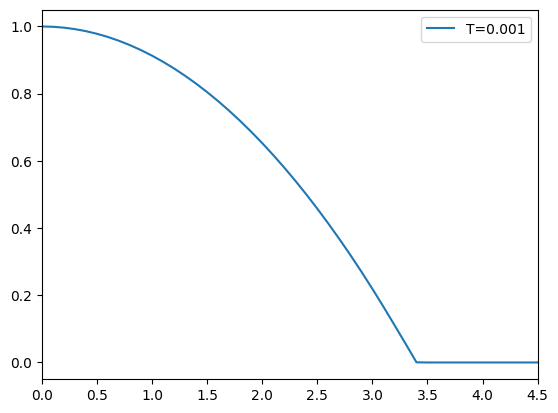

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

#print len(Uint_list)
#print len(Z_list_b10)
plt.plot(Uint_list,[z[0,0].real for z in Z_list],label="T=%.3f"%(1/beta))
plt.legend()
plt.xlim(0,4.5)

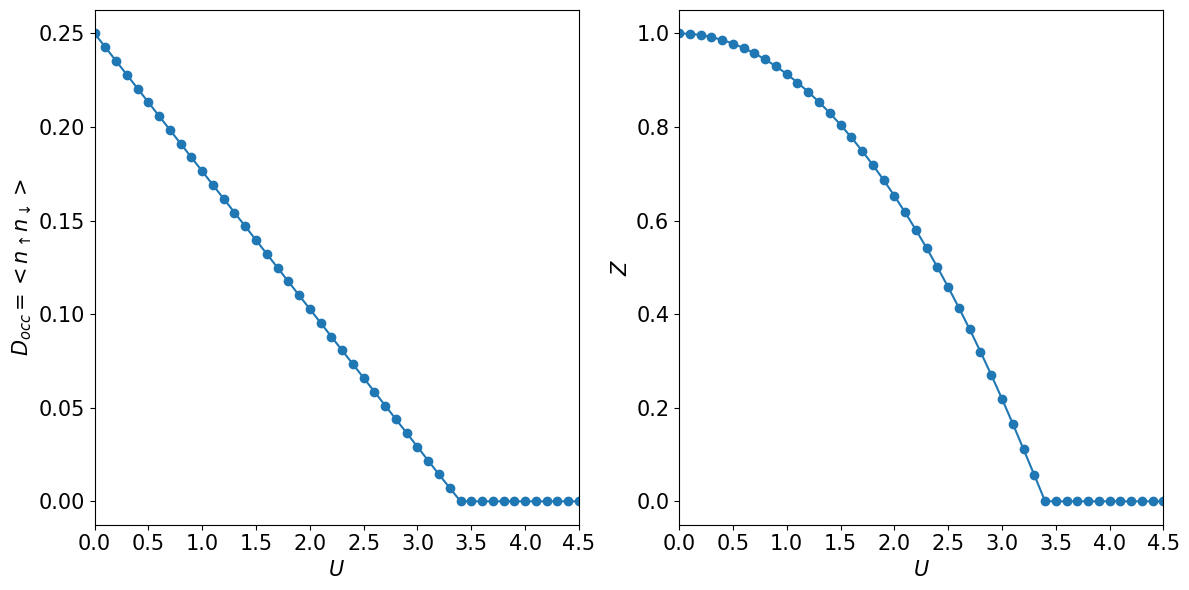

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(Uint_list,Docc_list,'o-')
plt.xlabel(r"$U$",size=15)
plt.ylabel(r"$D_{occ}=<n_{\uparrow}n_{\downarrow}>$",size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlim(0,4.5)

plt.subplot(1,2,2)
plt.plot(Uint_list,np.array(Z_list)[:,0,0].real,'o-')
plt.xlabel("$U$",size=15)
plt.ylabel("$Z$",size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlim(0,4.5)

plt.tight_layout()